In [1]:
import os
import sys
import cv2
import torch

import numpy as np
import matplotlib.pylab as plt
import torch.optim as optim
import torch.nn.functional as F

from VQVAE import VQVAE
from GatedPixelCNN import GatedPixelCNN
from config import setSeed, getConfig
from customLoader import MinecraftData, LatentBlockDataset

from pprint import pprint
from os.path import join
from pathlib import Path

from torchvision.utils import make_grid
from torchvision.transforms import transforms

from torch.utils.data import DataLoader

In [2]:
conf = {
  "experiment": "test_2",
  "environment": "MineRLNavigate-v0",
  "batch_size": 256,
  "num_training_updates": 25000,
  "learning_rate": 0.001,
  "split": 0.9,
  "vqvae": {
    "num_hiddens": 128,
    "num_residual_hiddens": 32,
    "num_residual_layers": 2,
    "embedding_dim": 64,
    "num_embeddings": 512,
    "commitment_cost": 0.25,
    "decay": 0.99
  },
  "pixelcnn": {
    "epochs": 100,
    "save": "no",
    "log_interval": 100,
    "lr": 0.0003,
    "img_dim": 16,
    "batch_size": 32,
    "num_hiddens": 64,
    "num_layers": 15,
    "gen_samples": "no"
  }
}

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [7]:
vqvae = VQVAE(**conf['vqvae']).to(device)

In [9]:
pixelcnn = GatedPixelCNN(conf['vqvae']['num_embeddings'], conf['pixelcnn']['img_dim']**2).to(device)

Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d


In [10]:
vqvae.eval()
pixelcnn.eval()

GatedPixelCNN(
  (embedding): Embedding(512, 256)
  (layers): ModuleList(
    (0): GatedMaskedConv2d(
      (class_cond_embedding): Embedding(10, 512)
      (vert_stack): Conv2d(256, 512, kernel_size=(4, 7), stride=(1, 1), padding=(3, 3))
      (vert_to_horiz): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (horiz_stack): Conv2d(256, 512, kernel_size=(1, 4), stride=(1, 1), padding=(0, 3))
      (horiz_resid): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (gate): GatedActivation()
    )
    (1): GatedMaskedConv2d(
      (class_cond_embedding): Embedding(10, 512)
      (vert_stack): Conv2d(256, 512, kernel_size=(2, 3), stride=(1, 1), padding=(1, 1))
      (vert_to_horiz): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (horiz_stack): Conv2d(256, 512, kernel_size=(1, 2), stride=(1, 1), padding=(0, 1))
      (horiz_resid): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (gate): GatedActivation()
    )
    (2): GatedMaskedConv2d(
      (class_cond_

In [12]:
weights_vqvae = torch.load(f"../weights/{conf['experiment']}/24999.pt")['state_dict']
vqvae.load_state_dict(weights_vqvae)

weights_pixelcnn = torch.load(f"../weights/{conf['experiment']}/pixel_6.pt")['state_dict']
pixelcnn.load_state_dict(weights_pixelcnn)

<All keys matched successfully>

In [44]:
batch = 8
label = torch.arange(batch).contiguous().view(-1)
label = label.long().to(device)
print(label)    

tensor([0, 1, 2, 3, 4, 5, 6, 7], device='cuda:0')


In [54]:
batch = 16
label = torch.zeros(batch).contiguous().view(-1)
label = label.long().to(device)
print(label)   

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [55]:
indices = pixelcnn.generate(label, batch_size=batch)

In [56]:
indices = indices.unsqueeze(dim=1)
print(indices.shape)
print(type(indices))


torch.Size([16, 1, 16, 16])
<class 'torch.Tensor'>


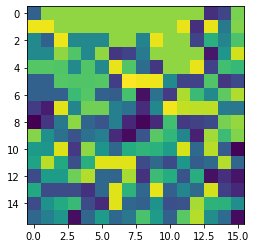

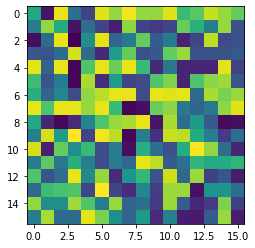

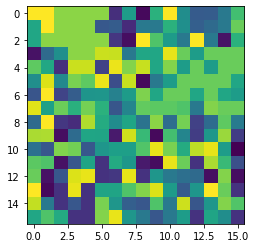

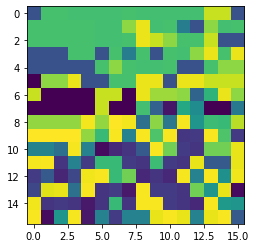

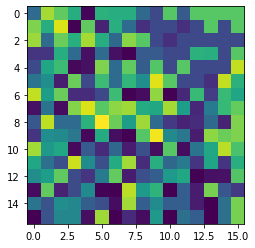

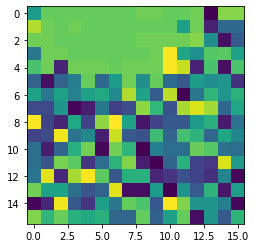

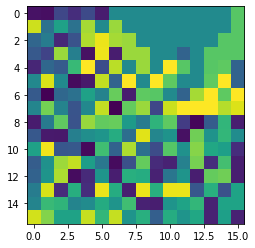

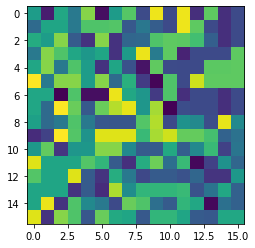

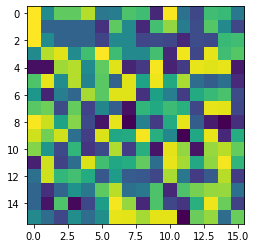

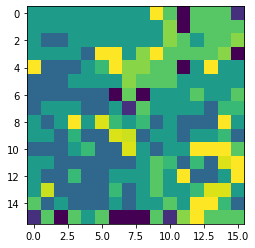

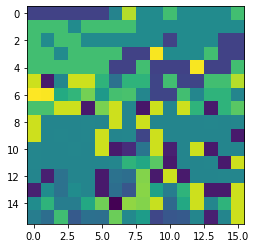

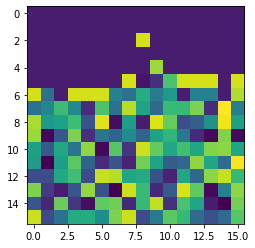

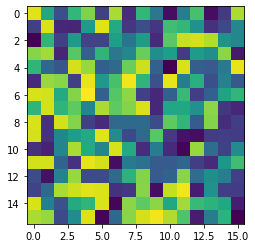

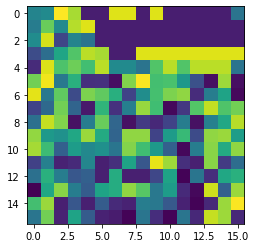

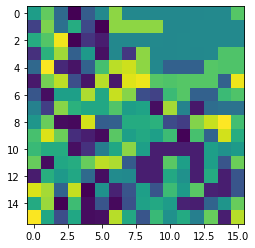

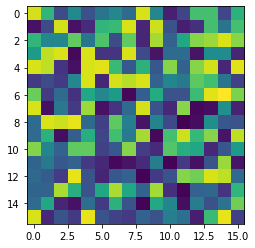

In [57]:
for i in indices:
    plt.imshow(i.permute(1,2,0).cpu().data)
    plt.show()

In [58]:
quantized = vqvae._vq_vae.indices2quantized(indices, batch)

In [59]:
generated = vqvae._decoder(quantized)


In [60]:
generated.shape

torch.Size([16, 3, 64, 64])

In [61]:
grid = make_grid(generated.cpu().data, normalize=True)

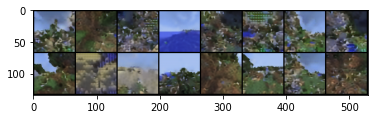

In [62]:
plt.imshow(grid.permute(1,2,0).numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


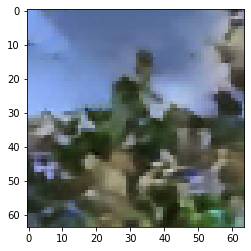

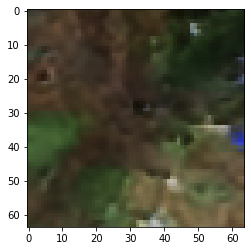

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


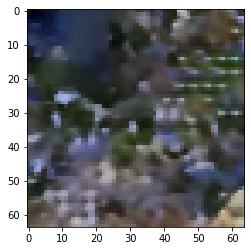

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


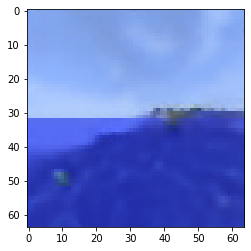

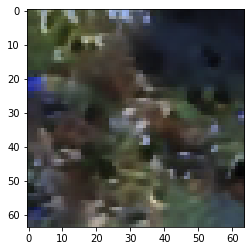

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


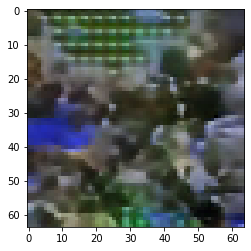

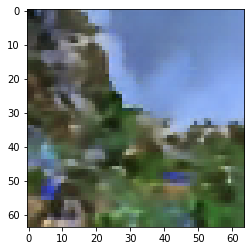

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


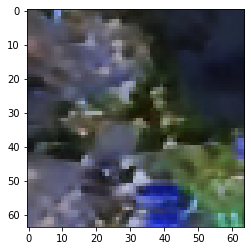

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


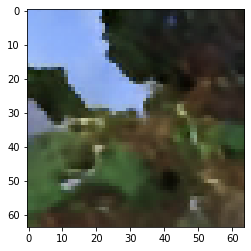

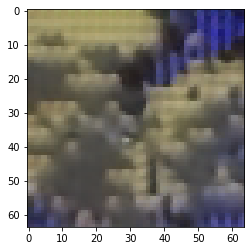

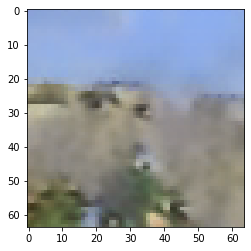

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


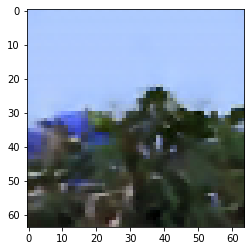

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


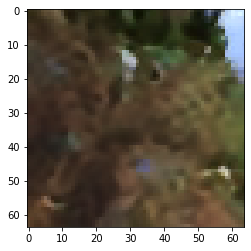

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


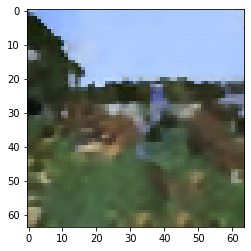

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


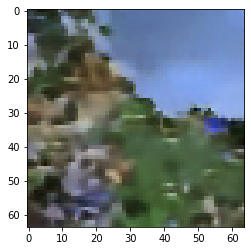

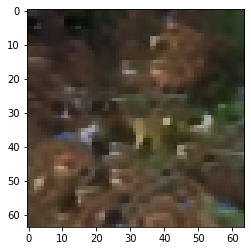

In [63]:
for i in generated:
    plt.imshow(i.permute(1,2,0).cpu().data+0.5)
    plt.show()